# Marketing analysis

## Table of Contents:
- [Goal](#goal)
- [Data](#data)
- [Usage Funnel](#usage-funnel)
    - [Quiz Funnel](#quiz-funnel)
        - [Data Investigation](#data-investigation-1)
        - [Survey Database Creation](#survey-database-creation)
        - [Quiz Funnel Creation](#quiz-funnel-creation)
    - [Home Try-On Funnel](#home-try-on-funnel)
        - [Data Investigation](#data-investigation-2)

## Goal <a class="anchor" id="goal"></a>

The goal of this project is getting customer related insights by:
- Applying *usage funnel* marketing model;
- Calculating one of the most important marketing metrics - *churn rate*;
- Ascertaining *first- and last-touch attribution* sources. 

All these techniques will be implemented using SQL queries, some results will be visualized to get a view of the data from a different angle.

## Data <a class="anchor" id="data"></a>

Unfortunately, no universal dataset was found for applying all listed marketing techniques at one go. Therefore, different datasets related to different companies will be used for each technique. All datasets are precleaned and contain aggregated information from companies: [Warby Parker](https://www.warbyparker.com), [Codeflix](https://codeflix.com) and "CoolTShirts". All data is provided by Codecademy.com.

## Usage Funnel <a class="anchor" id="usage-funnel"></a>

A usage funnel is a marketing model which illustrates the theoretical customer journey towards the purchase of a product or service. By applying it we want to apprehend the total number of users in each step of the funnel, as well as the percent of users who complete each step. In this part of the project, we will analyze different marketing funnels of an eyewear brand "Warby Parker" in order to calculate their conversion rates.  

There are 2 funnels we are going to build:
**Quiz Funnel**, which uses dataset `survey.csv` and **Home Try-On Funnel** based on datasets: `quiz.csv`, `home_try_on.csv`, `purchase.csv`.

### Quiz Funnel <a class="anchor" id="quiz-funnel"></a>

To help users find their perfect frame, Warby Parker has a [Style Quiz](https://www.warbyparker.com/quiz) that has the following questions:
- “What are you looking for?”
- “What’s your fit?”
- “Which shapes do you like?”
- “Which colors do you like?”
- “When was your last eye exam?”

The users’ responses are stored in the file `survey.csv`, so let's start with data imports and data investigation.


In [60]:
# Basic imports related to analysis
import pandas as pd
import numpy as np

# Imports related to database management
import sqlite3

# Import for visualisation
import seaborn as sns
from matplotlib import pyplot as plt
import plotly.express as px

#### Data Investigation <a class="anchor" id="data-investigation-1"></a>

Considering necessity to display and visualize results fetched from SQL database in the Notebook, we first are going to convert `csv` files to pandas `DataFrames` and after that create databases from these `DataFrames`.

In [11]:
survey = pd.read_csv('funnels_datasets/survey.csv')
survey

,question,user_id,response
0,1. What are you looking for?,005e7f99-d48c-4fce-b605-10506c85aaf7,Women's Styles
1,2. What's your fit?,005e7f99-d48c-4fce-b605-10506c85aaf7,Medium
2,3. Which shapes do you like?,00a556ed-f13e-4c67-8704-27e3573684cd,Round
3,4. Which colors do you like?,00a556ed-f13e-4c67-8704-27e3573684cd,Two-Tone
4,1. What are you looking for?,00a556ed-f13e-4c67-8704-27e3573684cd,I'm not sure. Let's skip it.
...,...,...,...
1981,5. When was your last eye exam?,ff48cdf3-e09e-4fb3-a46b-3751c9764dc7,<1 Year
1982,1. What are you looking for?,ff8461f7-e500-458c-9087-98fa63562d99,Women's Styles
1983,3. Which shapes do you like?,ff8461f7-e500-458c-9087-98fa63562d99,Rectangular
1984,4. Which colors do you like?,ff8461f7-e500-458c-9087-98fa63562d99,Tortoise


Result: Table contains only 3 columns `question`, `user_id` and `response`. Let's check some basic statistics of this set. 

In [14]:
survey.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1986 entries, 0 to 1985
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   question  1986 non-null   object
 1   user_id   1986 non-null   object
 2   response  1986 non-null   object
dtypes: object(3)
memory usage: 46.7+ KB


Result: As was mentioned before - dataset is precleaned and unlikely to contain any `null`s, so let's proceed to database creation. 

#### Survey Database Creation <a class="anchor" id="survey-database-creation"></a>

In [16]:
# Create new db
connect = sqlite3.connect('./funnels_datasets/survey.db')

# Create new table in db
survey.to_sql('Survey', connect, if_exists='replace', index=False)

# Create db cursor
cursor = connect.cursor()

Now we need to wrap each query in a python function that converts results back to `DataFrame`.

In [17]:
def sql(*args, **kwargs):
    cur = cursor.execute(*args, **kwargs)
    return pd.DataFrame(cur.fetchall(), columns=[column_name[0] for column_name in cur.description])

Now we can check how SQL queries' results are converted back to `DataFrame`. 

In [18]:
sql('''
    SELECT *
    FROM Survey
    LIMIT 5
''')

,question,user_id,response
0,1. What are you looking for?,005e7f99-d48c-4fce-b605-10506c85aaf7,Women's Styles
1,2. What's your fit?,005e7f99-d48c-4fce-b605-10506c85aaf7,Medium
2,3. Which shapes do you like?,00a556ed-f13e-4c67-8704-27e3573684cd,Round
3,4. Which colors do you like?,00a556ed-f13e-4c67-8704-27e3573684cd,Two-Tone
4,1. What are you looking for?,00a556ed-f13e-4c67-8704-27e3573684cd,I'm not sure. Let's skip it.


Everything seems fine, so let's proceed to the funnel building step. 

#### Quiz Funnel Creation <a class="anchor" id="quiz-funnel-creation"></a> 

Users will “give up” at different points in the survey. Let’s analyze how many users move from Question 1 to the next.

In [59]:
quiz_funnel = sql('''
    SELECT question,
    COUNT(DISTINCT user_id) AS users_count,
    COUNT(DISTINCT user_id) * 100 / LAG(COUNT(DISTINCT user_id), 1, COUNT(DISTINCT user_id)) OVER (
        ORDER BY 1
    ) AS percentages
    FROM Survey
    GROUP BY 1
''')
quiz_funnel

,question,users_count,percentages
0,1. What are you looking for?,500,100
1,2. What's your fit?,475,95
2,3. Which shapes do you like?,380,80
3,4. Which colors do you like?,361,95
4,5. When was your last eye exam?,270,74


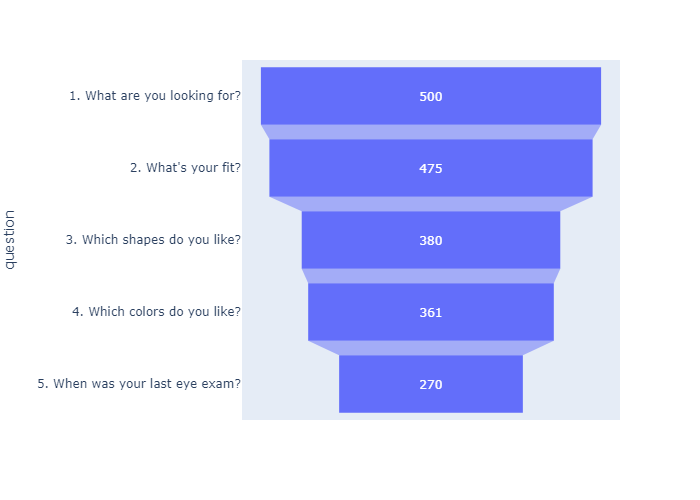

In [72]:
fig = px.funnel(quiz_funnel, x='users_count', y='question')
fig.show('png')

Result: 
- We can clearly see that the number of users answering each question, after the first one, is declining.
- Especially challenging are the 3rd and the 5th questions. The 3rd, because there could be several shapes that looking more or less good on them or the other way around - no such shapes that a person aware of. The 5th, because not many people remember when they have last been at doctor's checking eyesight. 
- 2nd question is related to constant physical parameters of a person, judging from the percentage of those who answered, they seem to be easily measurable for an ordinary user.
- color is a safe option after shape, because at this point one could easily select something neutral as black or silver just to be done with it.

### Home Try-On Funnel <a class="anchor" id="home-try-on-funnel"></a>
#### Data Investigation <a class="anchor" id="data-investigation-2"></a>

In [7]:
home_try_on = pd.read_csv('funnels_datasets/home_try_on.csv')
home_try_on

,user_id,number_of_pairs,address
0,d8addd87-3217-4429-9a01-d56d68111da7,5 pairs,145 New York 9a
1,f52b07c8-abe4-4f4a-9d39-ba9fc9a184cc,5 pairs,383 Madison Ave
2,8ba0d2d5-1a31-403e-9fa5-79540f8477f9,5 pairs,287 Pell St
3,4e71850e-8bbf-4e6b-accc-49a7bb46c586,3 pairs,347 Madison Square N
4,3bc8f97f-2336-4dab-bd86-e391609dab97,5 pairs,182 Cornelia St
...,...,...,...
745,99f1fad4-5142-45fd-a122-6185eadabf38,3 pairs,447 Ctrl Park Powell Blvd Appr
746,b5b3a93c-e143-478c-9284-cf51d09c4fa9,5 pairs,464 Greenwich Ave
747,12b0b516-2fb0-4da6-bb4d-a09f438ae96e,3 pairs,487 Perry St
748,2e3e3236-89fd-4e09-a4c9-babf7675819f,5 pairs,31 Wyckoff Ave


In [8]:
purchase = pd.read_csv('funnels_datasets/purchase.csv')
purchase

,user_id,product_id,style,model_name,color,price
0,00a9dd17-36c8-430c-9d76-df49d4197dcf,8,Women's Styles,Lucy,Jet Black,150
1,00e15fe0-c86f-4818-9c63-3422211baa97,7,Women's Styles,Lucy,Elderflower Crystal,150
2,017506f7-aba1-4b9d-8b7b-f4426e71b8ca,4,Men's Styles,Dawes,Jet Black,150
3,0176bfb3-9c51-4b1c-b593-87edab3c54cb,10,Women's Styles,Eugene Narrow,Rosewood Tortoise,95
4,01fdf106-f73c-4d3f-a036-2f3e2ab1ce06,8,Women's Styles,Lucy,Jet Black,150
...,...,...,...,...,...,...
490,fdb36b83-f7e5-475a-9165-336fc3a39ccc,6,Women's Styles,Olive,Pearled Tortoise,95
491,fdd0cc7d-b9fc-404e-9d95-f69b230d2e72,10,Women's Styles,Eugene Narrow,Rosewood Tortoise,95
492,fdf35090-5080-4d90-9204-7af788268837,10,Women's Styles,Eugene Narrow,Rosewood Tortoise,95
493,fee44777-bbd7-44ea-8102-291c89d0519b,1,Men's Styles,Brady,Layered Tortoise Matte,95


In [9]:
quiz = pd.read_csv('funnels_datasets/quiz.csv')
quiz

,user_id,style,fit,shape,color
0,4e8118dc-bb3d-49bf-85fc-cca8d83232ac,Women's Styles,Medium,Rectangular,Tortoise
1,291f1cca-e507-48be-b063-002b14906468,Women's Styles,Narrow,Round,Black
2,75122300-0736-4087-b6d8-c0c5373a1a04,Women's Styles,Wide,Rectangular,Two-Tone
3,75bc6ebd-40cd-4e1d-a301-27ddd93b12e2,Women's Styles,Narrow,Square,Two-Tone
4,ce965c4d-7a2b-4db6-9847-601747fa7812,Women's Styles,Wide,Rectangular,Black
...,...,...,...,...,...
995,b04d4c11-00bd-48a7-b886-957488d2e78d,Men's Styles,Narrow,Square,Neutral
996,468da0a9-4e0a-475c-afd3-5cbcade1f0d1,I'm not sure. Let's skip it.,Narrow,Rectangular,Crystal
997,1de6c3a5-f1b0-4622-a871-389aeeb5b8de,Men's Styles,Narrow,Round,Two-Tone
998,59f00e26-0b5c-4c9b-97ae-e1129a45b262,Women's Styles,I'm not sure. Let's skip it.,Square,Tortoise
